# **Needed Libraries**

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2024-08-15 16:57:37.774969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 16:57:37.775082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 16:57:37.918913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


# **Needed Functions**

## **Function to create data frame**

In [2]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

## **Function to generate images from dataframe**

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

## **Function to display data sample**

In [4]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

## **Callbacks** 

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience  
        self.stop_patience = stop_patience  # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold  # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # factor by which to reduce the learning rate
        self.batches = batches  # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch  # save this value to restore if restarting training

        # callback variables
        self.count = 0  # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1  # epoch with the lowest loss
        self.highest_tracc = 0.0  # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf  # set lowest validation loss to infinity initially
        self.initial_lr = None  # Will be set in `on_train_begin`
        self.best_weights = None  # Will be set in `on_train_begin`
        self.initial_weights = None  # Will be set in `on_train_begin`

## **Function to plot history of training**

In [6]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


## **Function to create Confusion Matrix**

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')

    else:
        print('Confusion Matrix, Without Normalization')

        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# **Model Structure**

## **Start Reading Dataset**

In [8]:
data_dir = '/kaggle/input/alzheimer-mri-dataset/Dataset'

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 5120 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.


## **Display Image Sample**

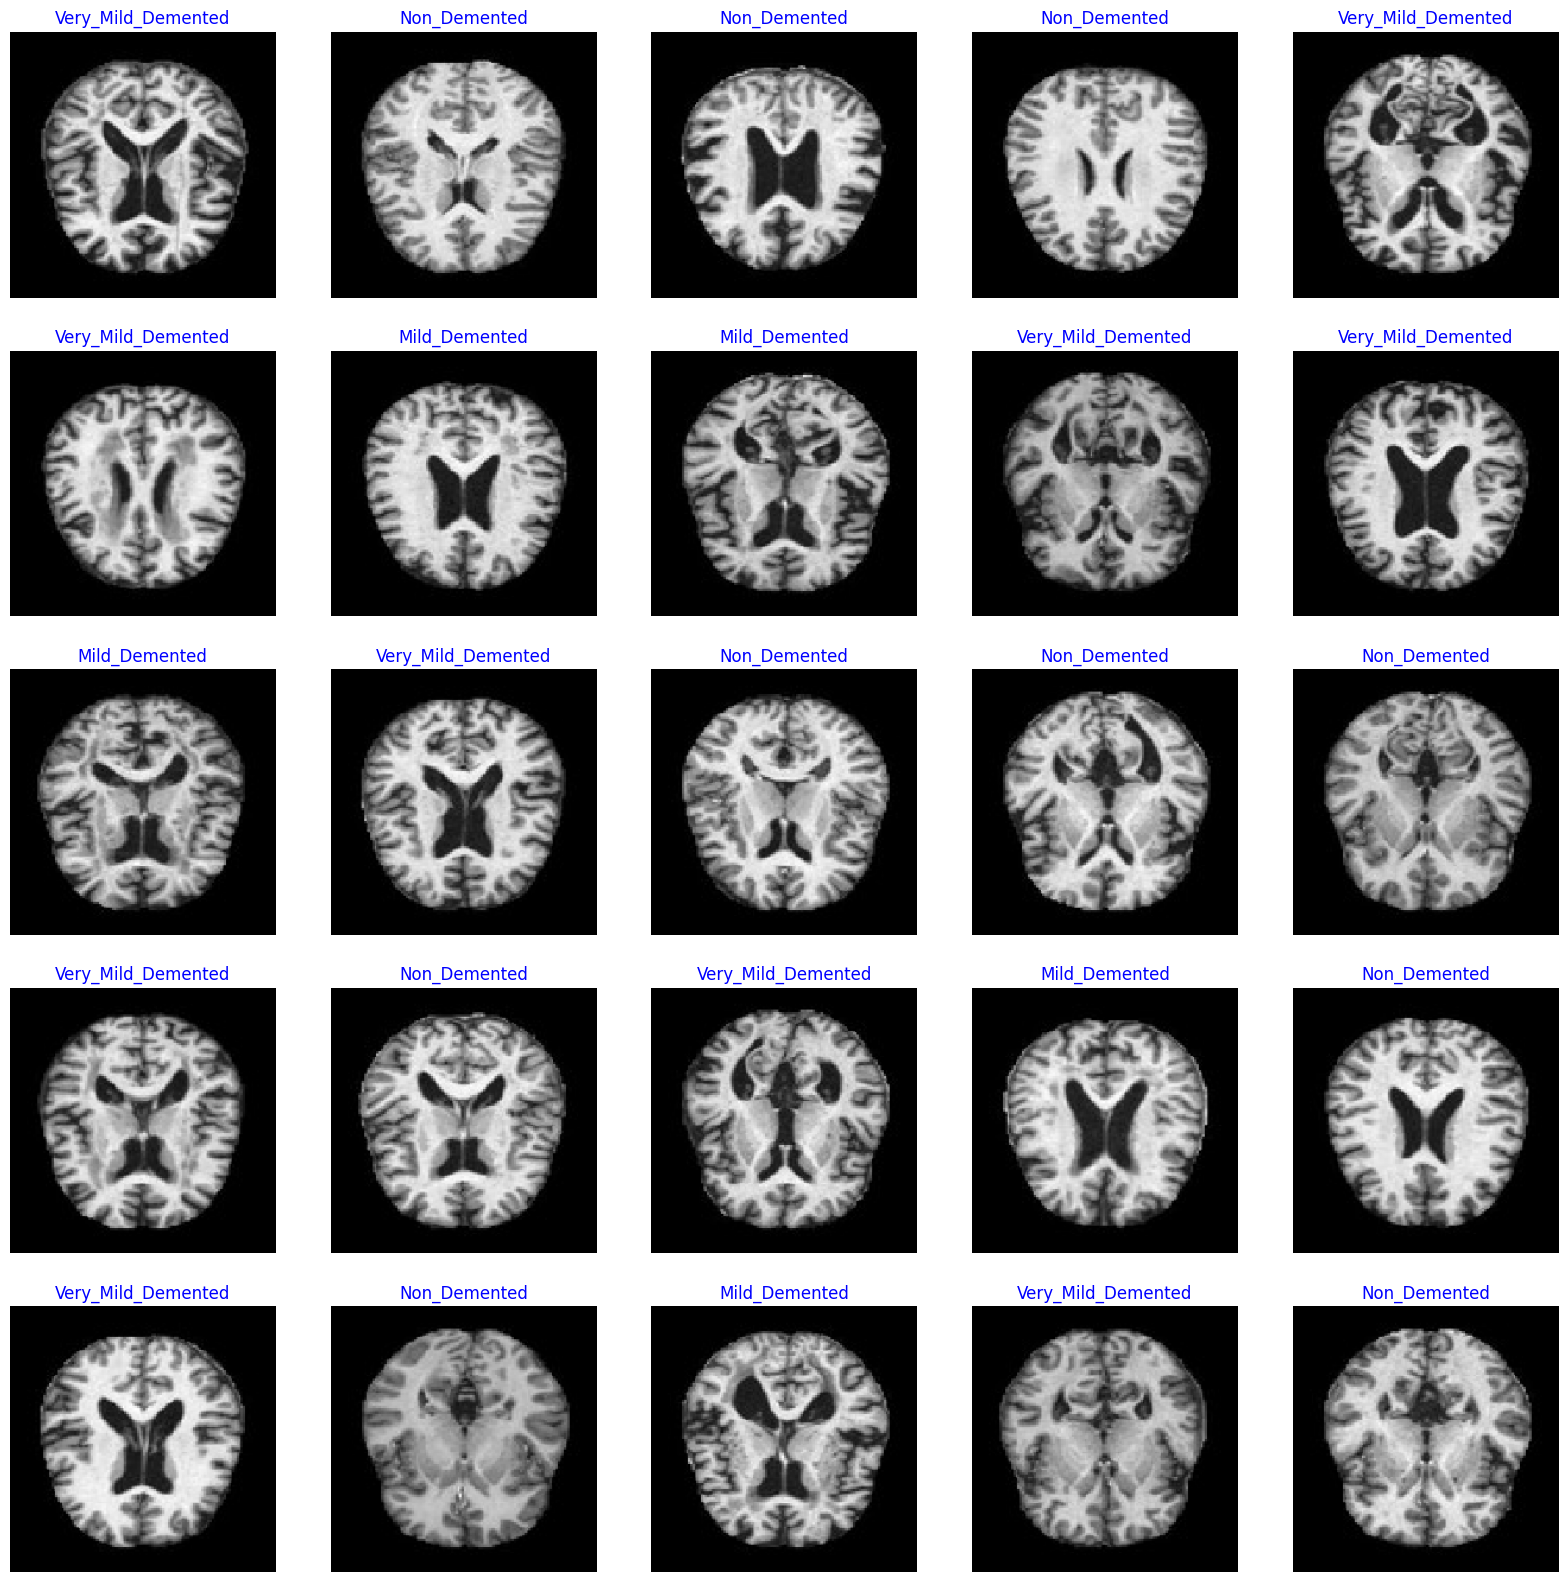

In [9]:
show_images(train_gen)

# **CNN Model**

In [10]:
def define_model():
    
    # define model
    model = Sequential()

    # 1st Convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd Convolutional layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd Convolutional layer
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 4th Convolutional layer
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=5, activation='softmax'))
    
    model.add(keras.layers.Dense(4, activation='softmax'))
    # compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
model = define_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            24 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,243,933 (100.11 MB)

 Trainable params: 26,243,933 (100.11 MB)

 Non-trainable params: 0 (0.00 B)

# **Set Callback Parameters**

In [12]:
batch_size = 40   
epochs = 40   
patience = 1   
stop_patience = 3   
threshold = 0.9   
factor = 0.5   
ask_epoch = 5
batches = int(np.ceil(len(train_gen.labels) / batch_size))    
callbacks = [MyCallback(patience, stop_patience, threshold, factor, batches, epochs, ask_epoch)]

## **Train model**

In [13]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs,
                    verbose=1, callbacks=callbacks, validation_steps=None, shuffle=False)

Epoch 1/40


2024-08-15 16:58:11.490789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.41492, expected 3.85372
2024-08-15 16:58:11.490864: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.30414, expected 2.74294
2024-08-15 16:58:11.490879: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 4.34396, expected 3.78276
2024-08-15 16:58:11.490890: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 4.06936, expected 3.50816
2024-08-15 16:58:11.490903: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.43262, expected 3.87142
2024-08-15 16:58:11.490921: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 4.44499, expected 3.88379
2024-08-15 16:58:11.490934: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64: 4.60205, expected 4.04085
2024-08-15 16:58:11.490945: E external/local_xla/

  1/128 ━━━━━━━━━━━━━━━━━━━━ 32:27 15s/step - accuracy: 0.2000 - loss: 1.5019

I0000 00:00:1723741101.215118      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723741101.238597      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4013 - loss: 1.2835

W0000 00:00:1723741132.341346      71 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


128/128 ━━━━━━━━━━━━━━━━━━━━ 49s 269ms/step - accuracy: 0.4016 - loss: 1.2833 - val_accuracy: 0.5000 - val_loss: 1.1504
Epoch 2/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.5016 - loss: 1.2523 - val_accuracy: 0.5000 - val_loss: 1.1853
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.5032 - loss: 1.1775 - val_accuracy: 0.5000 - val_loss: 1.1347
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5002 - loss: 1.1191 - val_accuracy: 0.5000 - val_loss: 1.1061
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.4987 - loss: 1.0950 - val_accuracy: 0.5000 - val_loss: 1.0880
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.5003 - loss: 1.0863 - val_accuracy: 0.5000 - val_loss: 1.0757
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.5028 - loss: 1.0620 - val_accuracy: 0.5000 - val_loss: 1.0669
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.4872 - loss: 1.0678 - val_accura

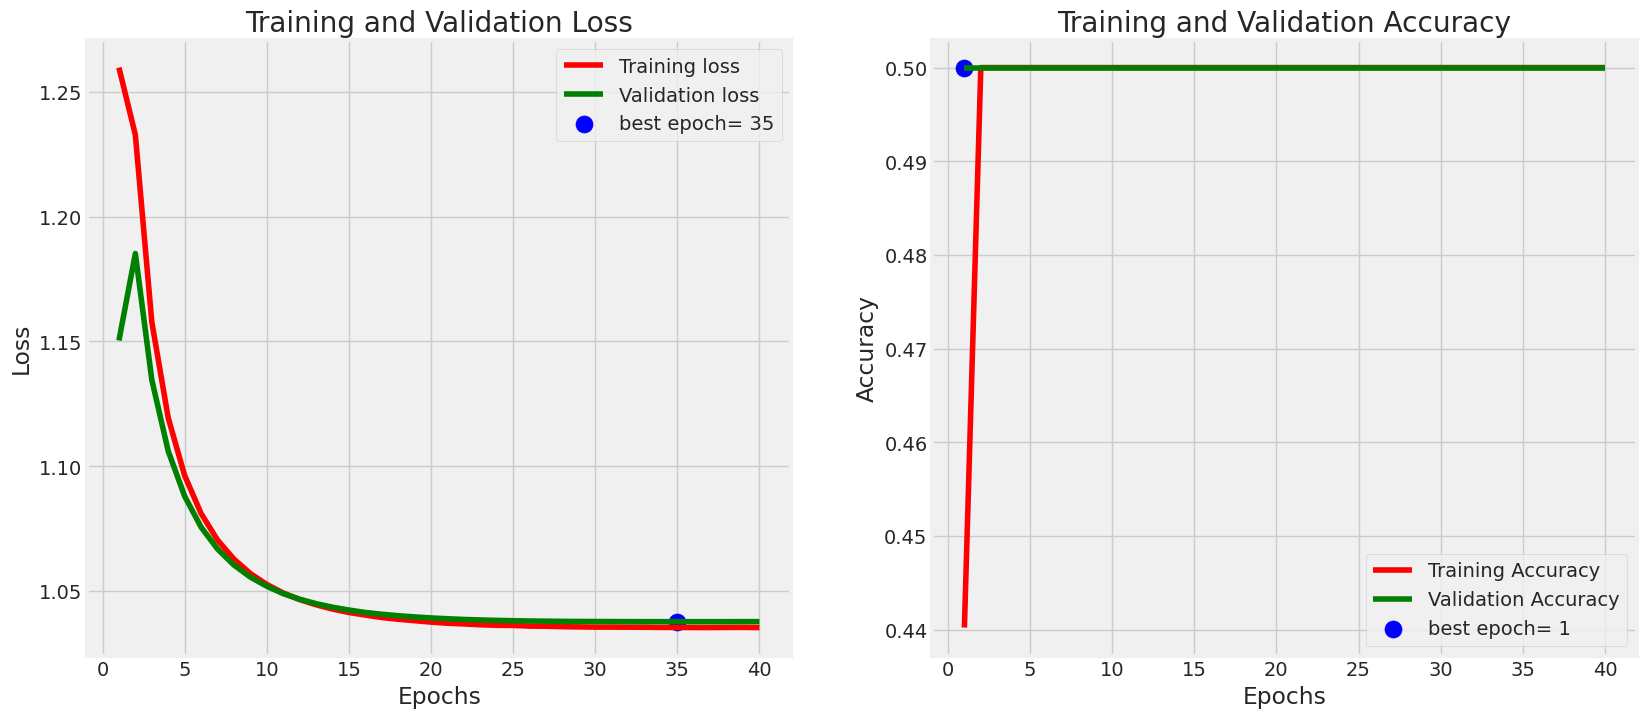

In [14]:
plot_training(history)

# **Evaluate CNN model**

In [15]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5230 - loss: 1.0189
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5216 - loss: 1.0249


2024-08-15 17:06:00.425410: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200704: 4.17004, expected 3.28353
2024-08-15 17:06:00.425535: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200705: 5.36153, expected 4.47501
2024-08-15 17:06:00.425551: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200706: 5.91983, expected 5.03332
2024-08-15 17:06:00.425567: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200707: 5.90032, expected 5.01381
2024-08-15 17:06:00.425585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200708: 5.05516, expected 4.16864
2024-08-15 17:06:00.425601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200709: 5.86708, expected 4.98057
2024-08-15 17:06:00.425612: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 200710: 5.77649, expected 4.88998
2024-08-15 17:06:00.

1/8 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.4875 - loss: 0.9572

W0000 00:00:1723741565.620598      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.5042 - loss: 1.0071
Train Loss:  1.0053585767745972
Train Accuracy:  0.5
--------------------
Validation Loss:  1.029604196548462
Validation Accuracy:  0.512499988079071
--------------------
Test Loss:  1.0337177515029907
Test Accuracy:  0.5


# **ResNet50 model**

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Change to the number of classes you have

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=epochs,
                    verbose=1, callbacks=callbacks, validation_steps=None, shuffle=False)

Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - accuracy: 0.4908 - loss: 1.8043 - val_accuracy: 0.5922 - val_loss: 0.8772
Epoch 2/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.5907 - loss: 0.8958 - val_accuracy: 0.6156 - val_loss: 0.8278
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6165 - loss: 0.8288 - val_accuracy: 0.6141 - val_loss: 0.9124
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.6093 - loss: 0.8535 - val_accuracy: 0.6156 - val_loss: 0.8234
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.6541 - loss: 0.7571 - val_accuracy: 0.6547 - val_loss: 0.7866
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.6544 - loss: 0.7475 - val_accuracy: 0.6375 - val_loss: 0.7973
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.6895 - loss: 0.7012 - val_accuracy: 0.6203 - val_loss: 0.8216
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.7021 - loss: 0.6728 -

## **Unfreeze Some Layers and Fine-tune**

In [19]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-10:]:  # Adjust the number of layers to unfreeze as needed
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training with the unfrozen layers
history_fine = model.fit(train_gen, validation_data=valid_gen, epochs=epochs,
                         verbose=1, callbacks=callbacks, validation_steps=None, shuffle=False)


Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 29s 127ms/step - accuracy: 0.7784 - loss: 0.8637 - val_accuracy: 0.8234 - val_loss: 0.4871
Epoch 2/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.9330 - loss: 0.1913 - val_accuracy: 0.8375 - val_loss: 0.3929
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.9635 - loss: 0.1135 - val_accuracy: 0.8344 - val_loss: 0.4592
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9667 - loss: 0.1027 - val_accuracy: 0.8641 - val_loss: 0.3951
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9698 - loss: 0.0909 - val_accuracy: 0.8547 - val_loss: 0.3953
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.9770 - loss: 0.0664 - val_accuracy: 0.8453 - val_loss: 0.4423
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9806 - loss: 0.0622 - val_accuracy: 0.8250 - val_loss: 0.5085
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9766 - loss: 0.0703 -

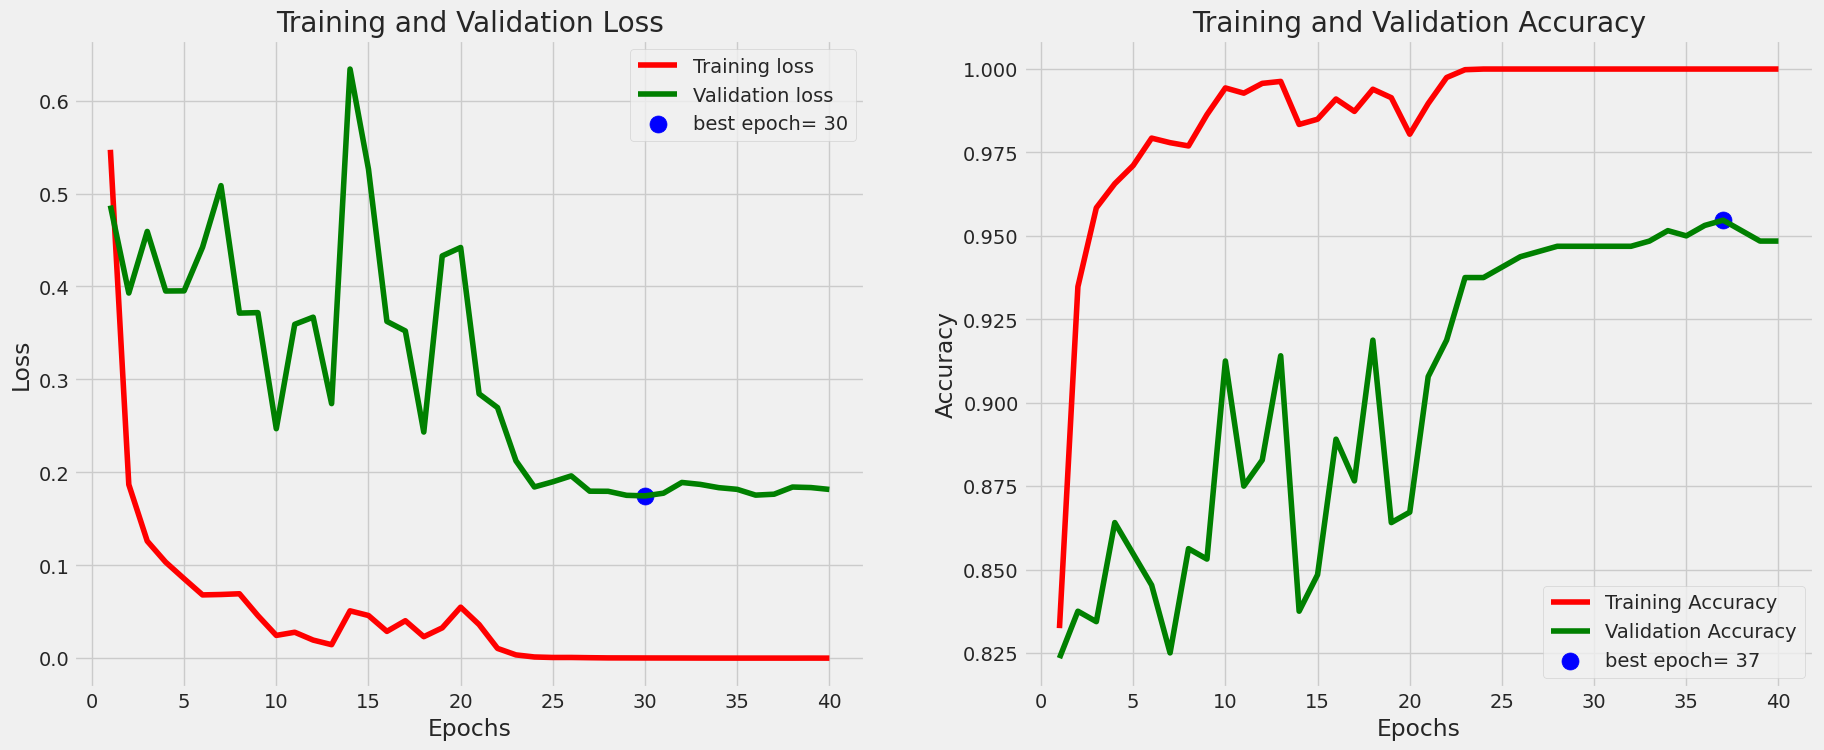

In [20]:
plot_training(history_fine)

# **Get Predictions**

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step


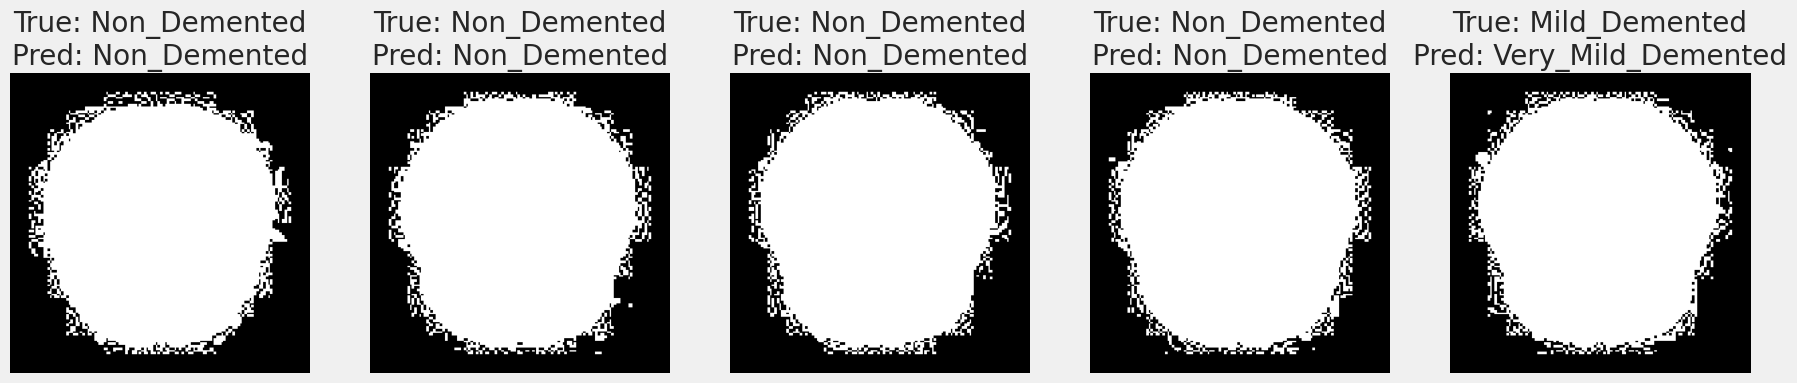

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
predicted_labels = [class_labels[i] for i in predicted_classes]

# Reset the test generator to read images again
test_gen.reset()

# Get a batch of images and labels from the test generator
images, labels = next(test_gen)

# Function to plot images with true and predicted labels
def plot_images(images, true_labels, predicted_labels, class_labels, n_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_labels[np.argmax(true_labels[i])]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.show()

# Plot the images
plot_images(images, labels, predicted_labels, class_labels, n_images=5)

## **Confusion Matrics and Classification Report**

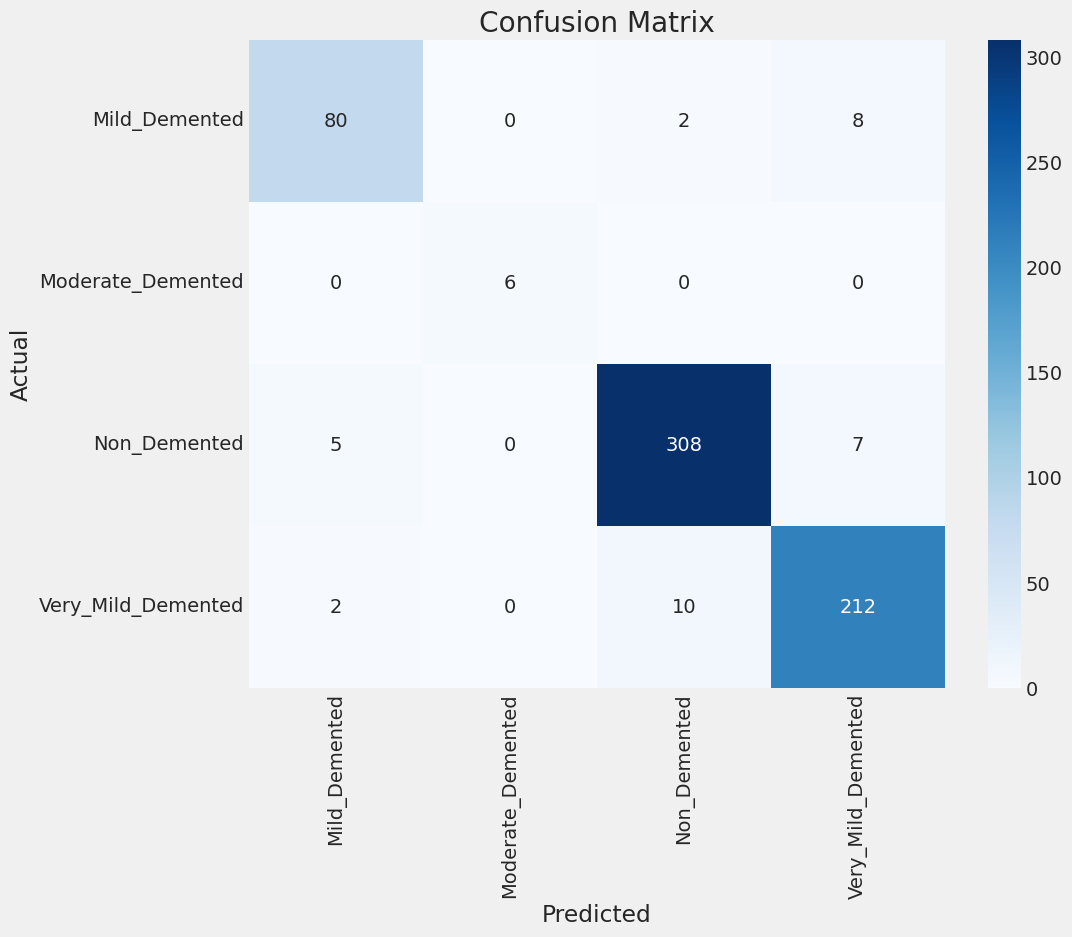

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [23]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                    precision    recall  f1-score   support

     Mild_Demented       0.92      0.89      0.90        90
 Moderate_Demented       1.00      1.00      1.00         6
      Non_Demented       0.96      0.96      0.96       320
Very_Mild_Demented       0.93      0.95      0.94       224

          accuracy                           0.95       640
         macro avg       0.95      0.95      0.95       640
      weighted avg       0.95      0.95      0.95       640

